# KNN
새로운 데이터가 주어졌을 때 가장 가까운 K개의 이웃을 찾아 그들의 레이블을 참고하여 예측

1. K값 설정: 몇 개의 이웃을 참조할지 K 값을 설정합니다.

2. 거리 계산: 새로운 입력 데이터와 기존 학습 데이터 간의 거리를 계산합니다.

3. K개의 최근접 이웃 선택: 가장 가까운 K개의 데이터를 선택합니다.

4. 다수결: 이웃 중 가장 많이 등장한 클래스(label)를 예측 결과로 반환합니다.

# 데이터준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load_dataset을 사용해 데이터프레임으로 변환
df = sns.load_dataset('titanic')

In [3]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# 데이터탐색

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [5]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# 데이터 통계 요약정보 확인 (범주형)
df.describe(include='object')

,sex,embarked,who,embark_town,alive
count,891,889,891,889,891
unique,2,3,3,3,2
top,male,S,man,Southampton,no
freq,577,644,537,644,549


In [7]:
# 누락데이터 확인
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [9]:
# 중복데이터 확인
df.duplicated().sum()

np.int64(107)

In [10]:
# 목표 변수의 분포 확인
df['survived'].value_counts()

,count
survived,
0,549
1,342


<Axes: xlabel='survived', ylabel='count'>

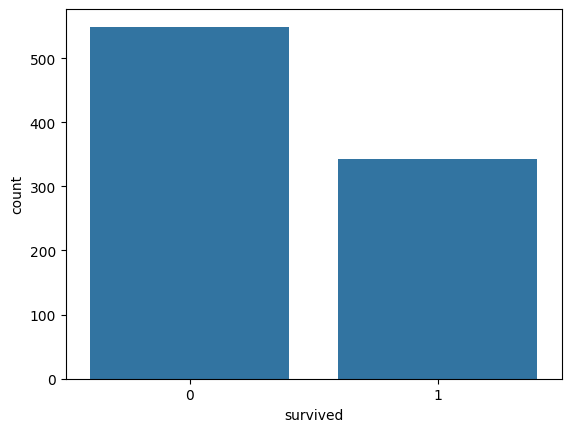

In [11]:
# 목표 변수 - 시각화
sns.countplot(data=df, x='survived')

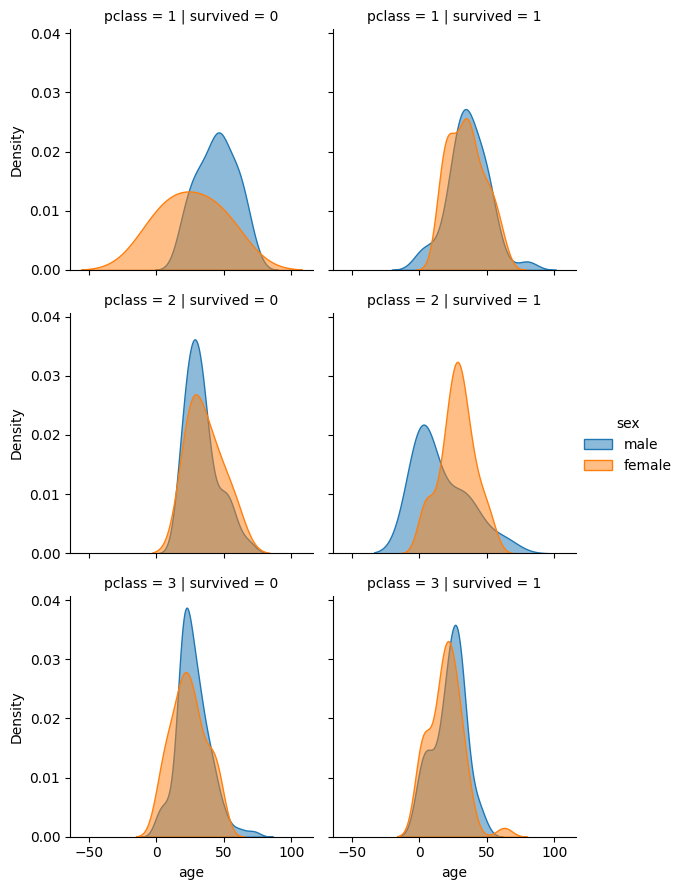

In [13]:
# 시각화
# hue='sex': 성별에 따라 색상 다르게
# alpha: 투명도 조절 파라미터
g = sns.FacetGrid(df, col='survived', row='pclass', hue='sex')
g.map(sns.kdeplot, 'age', alpha=0.5, fill=True)
g.add_legend();

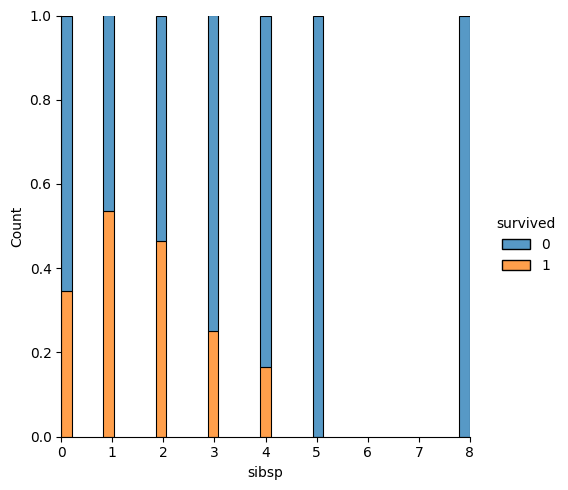

In [16]:
# 시각화
sns.displot(x='sibsp', kind='hist', hue='survived', data=df, multiple='fill');

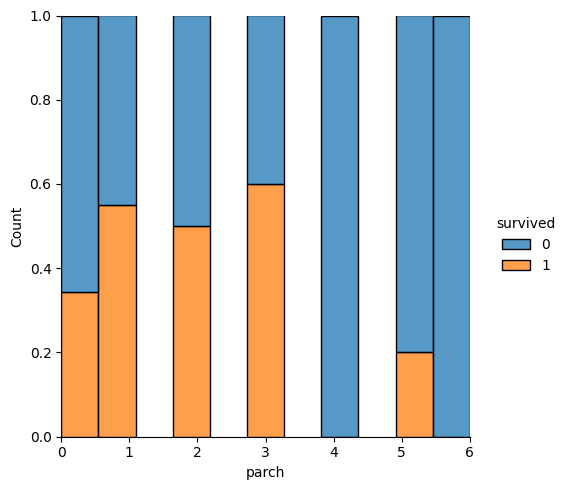

In [17]:
# 시각화
sns.displot(x='parch', kind='hist', hue='survived', data=df, multiple='fill')

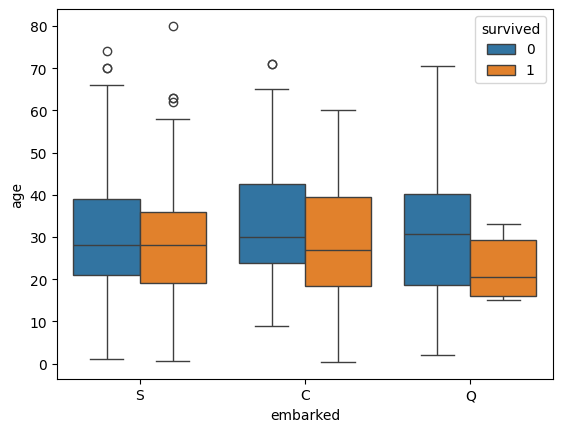

In [18]:
# 시각화
# embarked: 탑승항구
sns.boxplot(x='embarked', y='age', hue='survived', data=df);

**머신러닝에서 중복 데이터를 제거해야 하는 이유**

중복 데이터가 존재할 경우, 중복 데이터가 갖는 특정 패턴에 과적합되어 일반화 성능이 떨어지는 문제 발생.

또한, 데이터 불균형 문제를 심화시키고 학습 효율성 저하 -> 모델 평가의 정확성 왜곡

# 데이터 전처리

In [19]:
# 중복 데이터 제거
print('중복 제거 이전:', df.shape)
df = df.drop_duplicates()
print('중복 제거 이후:', df.shape)

중복 제거 이전: (891, 15)
중복 제거 이후: (784, 15)


In [23]:
# Nan 값이 많은 deck열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck','embark_town'], axis=1)
rdf.columns.values

array(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'alive', 'alone'],
      dtype=object)

In [25]:
# age 열에 나이 데이터가 없는 모든 행 삭제
# how='any': 하나라도 결측값이 있으면 해당 행을 제거
rdf = rdf.dropna(subset=['age'], how='any', axis=0)
print(len(rdf))

678


In [26]:
# embarked 열의 Nan 값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
# drop=True: Nan 값은 drop
# idxmax(): 빈도수가 높은 값 반환
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
print(most_freq)

S


In [27]:
# 최빈값으로 누락 데이터 치환
rdf['embarked'] = rdf['embarked'].fillna(most_freq)

In [28]:
# 결측치 확인하기
rdf.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,0
class,0
who,0


In [39]:
# 분석에 활용할 열 선택
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
ndf.head()

,survived,pclass,sex,age,sibsp,parch,embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [40]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

# prefix: 컬럼 앞에 붙일 접두사, 'S', 'C', 'Q' → town_S, town_C, town_Q
onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

# 기존의 sex, embarked 열 지우기
ndf = ndf.drop(['sex','embarked'], axis=1)
ndf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,False,True,False,False,True
1,1,1,38.0,1,0,True,False,True,False,False
2,1,3,26.0,0,0,True,False,False,False,True
3,1,1,35.0,1,0,True,False,False,False,True
4,0,3,35.0,0,0,False,True,False,False,True


# 훈련/검증 데이터 분할

In [41]:
# 속성 변수 선택
X = ndf[['pclass','age','sibsp','parch','female','male','town_C','town_Q','town_S']] # 설명변수 X
y = ndf[['survived']] # 예측 변수 y

설명 변수 데이터를 정규화 (normalization)

데이터 전처리 도구들을 모아둔 모듈 preprocessing을 불러옴

StandardScaler: 표준화(standardization)를 수행하는 도구

왜 표준화를 할까? K-Means, SVM, KNN, PCA 같은 알고리즘은 거리 기반 계산을 하기 때문에,
특성들의 스케일이 다르면 성능이 나빠질 수 있음

fit(X): X의 평균과 표준편차를 계산

transform(X): 위 통계를 사용해서 실제로 데이터를 변환

In [50]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data와 test data를 7:3으로 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print('train data 개수:', X_train.shape)
print('test data 개수:', X_test.shape)

train data 개수: (474, 9)
test data 개수: (204, 9)


# 모델 학습 및 검증

In [52]:
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (k=5로 설정)
# 가장 가까운 이웃 5개를 사용하겠다. 보통 k는 홀수로 지정. 짝수로 지정할 경우 동점이 될 수 있음
knn = KNeighborsClassifier(n_neighbors=5)

# train data를 가지고 모형 학습
knn.fit(X_train, y_train)

# test data를 가지고 y_hat 예측(분류)
y_hat = knn.predict(X_test) # y_hat: 예측된 값

print(y_hat[0:10]) # 예측된 값 10개
print(y_test.values[0:10]) # 실제 정답 10개



[0 1 0 1 0 0 1 1 1 1]
[[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]]


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [53]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics
knn_matrix = metrics.confusion_matrix(y_test, y_hat)
print(knn_matrix)

[[99 24]
 [26 55]]


**해석하는 법**

TN (True Negative)	실제 0이고 예측도 0 (정답)	99

FP (False Positive)	실제 0인데 예측은 1 (오답, Type I error)	24

FN (False Negative)	실제 1인데 예측은 0 (오답, Type II error)	26

TP (True Positive)	실제 1이고 예측도 1 (정답)	55

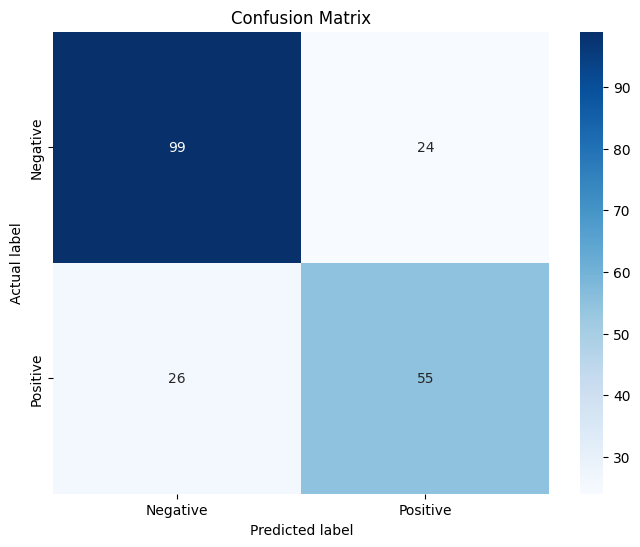

In [59]:
# Confusion Matrix 시각화
# annot=True: 각 셀에 숫자값(정수)을 표시
# fmt='d': 포맷 정수로 입력
plt.figure(figsize=(8, 6))
sns.heatmap(knn_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [60]:
# 모형 성능 평가 - 평가지표 계산
knn_report = metrics.classification_report(y_test,y_hat)
print(knn_report)

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       123
           1       0.70      0.68      0.69        81

    accuracy                           0.75       204
   macro avg       0.74      0.74      0.74       204
weighted avg       0.75      0.75      0.75       204

